In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor


from sklearn.model_selection import train_test_split

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#from utils import generate_heatmaps,dataframe_apply_func_axis_1

DATA_ROOT_PATH = "/content/drive/MyDrive/Colab Notebooks/Estsoft_Wassup_AI/kaggle/data/" # ../에서 수정
DATASET_NAME = "diabetes"

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
df_train = pd.read_csv(f"{DATA_ROOT_PATH}/{DATASET_NAME}.csv")
df_train

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [6]:
df_train.info()

NameError: ignored

In [7]:
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


# 상관관계 분석
- Dataset 을 따로 분리하지 않고 분석을 시작한다.
- 추후 Train 과 검증할 때 데이터 분리가 필요하다.

In [8]:
# 편한 문석을 위해 Outcome column 을 제일 앞에 둡니다.
# heatmap 에서 볼 때, 제일 윗줄이 Outcome 이 되도록..! 보면 됩니다.
cols = df_origin.columns.tolist()
cols = [cols.pop(), *cols]
cols

['Outcome',
 'Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [9]:
df_origin = df_origin[cols]
df_origin

,Outcome,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,1,6,148,72,35,0,33.6,0.627,50
1,0,1,85,66,29,0,26.6,0.351,31
2,1,8,183,64,0,0,23.3,0.672,32
3,0,1,89,66,23,94,28.1,0.167,21
4,1,0,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...,...
763,0,10,101,76,48,180,32.9,0.171,63
764,0,2,122,70,27,0,36.8,0.340,27
765,0,5,121,72,23,112,26.2,0.245,30
766,1,1,126,60,0,0,30.1,0.349,47


In [10]:
# 전체적인 상관관계 체크
corr = df_origin.corr()
corr_abs = corr.map(abs) # AttributeError: 'DataFrame' object has no attribute 'map'발생함

generate_heatmaps(
  [corr, corr_abs],
  ["Correlation of every columns", "Correlation of every columns - abs version"],
  21,
  annotation=True
)

AttributeError: ignored

## 전체적인 상관관계
### Correlation of every columns - abs version 그래프
- 포도당(Glucose) 이 Outcome column 과 가장 높은 상관관계를 보여준다.
  - 포도당과 높은 상관관계를 갖는 column 은 Outcome 다음으론 인슐린(Insulin) 이다.
  - 인슐린 다음으로는 BMI 와 Age 가 있다.
#
- BMI 가 포도당 다음으로 Outcome 과 높은 상관관계를 보여줬다.
  - BMI 와 높은 상관관계를 보여주는 항목은 피부 두께 (Skin Thickness) 이다.
#
- 다음으로 임신한 횟수 (Pregnancies) 와 나이 (Age) 가 0.2 초중반의 비슷한 상관관계를 보여준다.
  - Age 와 상관관계가 높은건 역시 Pregnancies 이다.
  - Age 는 포도당과 혈압하고 0.2 중반대의 상관관계를 보여준다.
  - Pregnancies 는 포도당과 혈압하고 0.1 초중반의 낮은 상관관계를 보여준다.
#
#
### Correlation of every columns 그래프 참고
- 주목할만한 역관계성은 거의 것 같다.

## 포도당 (Glucose) 세부 분석
- 포도당 검사를 통해 당뇨병을 진단한다.
- 인터넷 검색 결과 당뇨 확인을 위한 포도당 수치
  - 정상 수치는 140 mg/dL 미만,
  - 200 mg/dL 미만은 당뇨병 전 단계,
  - 200 mg/dL 이상은 당뇨병
#
- 포도당을 카테고리화 하여 Outcome 과의 관계성이 높아지는지 확인한다.
- 포도당과 상관관계가 높은 컬럼들을 분석하여 관계성을 높여본다.

In [11]:
# 당뇨병은 인슐린의 분비량이 부족하거나 정상적인 기능이 이루어지지 않는 등의 대사질환의 일종으로, 혈중 포도당의 농도가 높아지는 고혈당을 특징으로 한다.
# 인슐린은 간에서 포도당의 생성을 억제하고 근육을 포함한 말초조직으로 포도당 흡수를 촉진하여 혈중 포도당 농도를 낮춥니다.

df_glucose = df_origin.copy()[['Outcome', 'Glucose', 'Insulin', 'BMI', 'Age']]
df_glucose

,Outcome,Glucose,Insulin,BMI,Age
0,1,148,0,33.6,50
1,0,85,0,26.6,31
2,1,183,0,23.3,32
3,0,89,94,28.1,21
4,1,137,168,43.1,33
...,...,...,...,...,...
763,0,101,180,32.9,63
764,0,122,0,36.8,27
765,0,121,112,26.2,30
766,1,126,0,30.1,47


In [12]:
# 포도당 수치를 카테고리화 한다.
# 140 미만, 140 이상 200 미만, 200 이상

# 140 미만은 정상수치라고 했으나 그럼에도 불구하고 당뇨병 진단을 받은 사람들이 있다.
df_glucose.loc[df_glucose.Glucose < 140, ['Outcome']].sum()

Outcome    133
dtype: int64

In [13]:
# 140 을 정상인의 기준으로 하면 안될 것 같다.
df_glucose.loc[df_glucose.Glucose >= 140, ['Outcome']].sum()

Outcome    135
dtype: int64

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 31.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 22.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 38.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 35.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


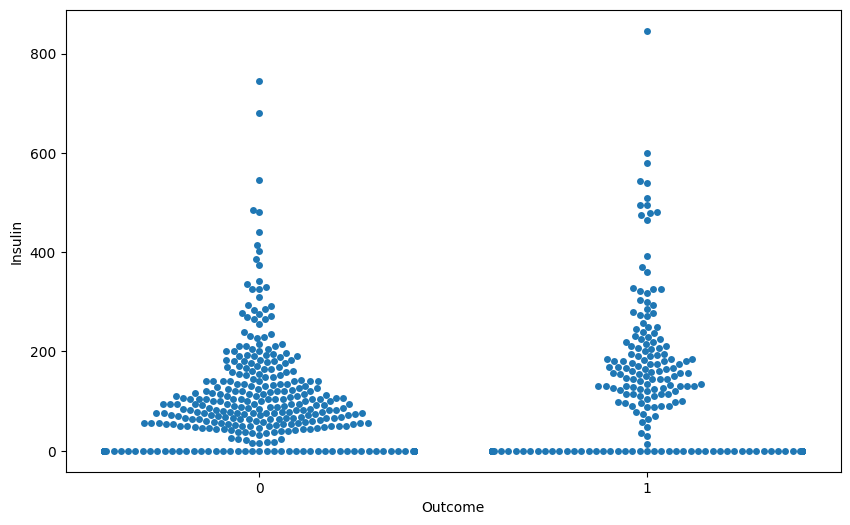

In [14]:
plt.figure(figsize=(10, 6))
sns.swarmplot(x="Outcome", y="Insulin", data=df_glucose[['Insulin','Outcome']])
plt.show()

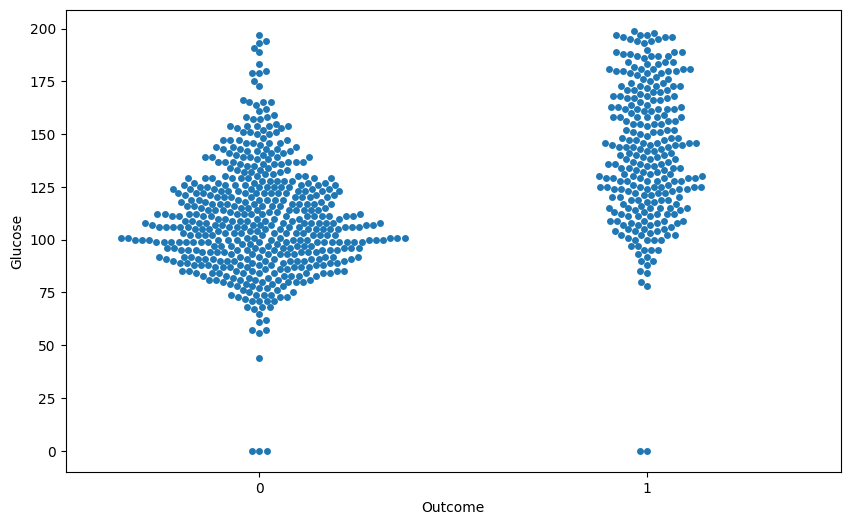

In [15]:
plt.figure(figsize=(10, 6))
sns.swarmplot(x="Outcome", y="Glucose", data=df_glucose[['Glucose','Outcome']])
plt.show()

In [16]:
# Glucose 가 0 인 수치의 outlier 들의 데이터 확인
# 아무래도 결측치가 저렇게 들어간 것 같다.
df_glucose.sort_values('Glucose').head(10)

,Outcome,Glucose,Insulin,BMI,Age
75,0,0,0,24.7,22
502,1,0,0,39.0,41
349,1,0,0,41.0,37
342,0,0,0,32.0,22
182,0,0,23,27.7,21
62,0,44,0,25.0,36
680,0,56,45,24.2,22
537,0,57,0,21.7,67
146,0,57,0,32.8,41
352,0,61,0,34.4,46


In [17]:
# 결측치를 채우기위해 임시 데이터셋 분리
df_glucose_null = df_glucose.loc[df_glucose.Glucose == 0]
df_glucose = df_glucose.loc[df_glucose.Glucose != 0]

In [18]:
# Glucose 의 결측치를 채우기 위해 나이대별, BMI 별 Glucose 의 평균을 구해보자
df_glucose.groupby('Outcome').median

<bound method GroupBy.median of <pandas.core.groupby.generic.DataFrameGroupBy object at 0x7c60df1cbf70>>

In [19]:
# 포도당(Glucose)은 인슐린과 상관관계(0.33)가 높다.
df_glucose.groupby('Outcome').mean() # outcome 별 Glucose 평균 값

,Glucose,Insulin,BMI,Age
Outcome,,,,
0,110.643863,69.160966,30.317304,31.247485
1,142.319549,101.090226,35.106015,37.052632


In [21]:
# 결측치 채우기
df_glucose_null = df_glucose_null.apply(
  dataframe_apply_func_axis_1(
    condition={'Outcome': 1},
    do_when_true={'Glucose': 140.0},
    do_when_false={'Glucose': 107.0}
  ),
  axis=1
)
df_glucose_null

NameError: ignored

In [22]:
# concat 두번되지 않도록 주의!!!!
df_glucose = pd.concat([df_glucose, df_glucose_null])
df_glucose.sort_index(inplace=True)
df_glucose

,Outcome,Glucose,Insulin,BMI,Age
0,1,148,0,33.6,50
1,0,85,0,26.6,31
2,1,183,0,23.3,32
3,0,89,94,28.1,21
4,1,137,168,43.1,33
...,...,...,...,...,...
763,0,101,180,32.9,63
764,0,122,0,36.8,27
765,0,121,112,26.2,30
766,1,126,0,30.1,47


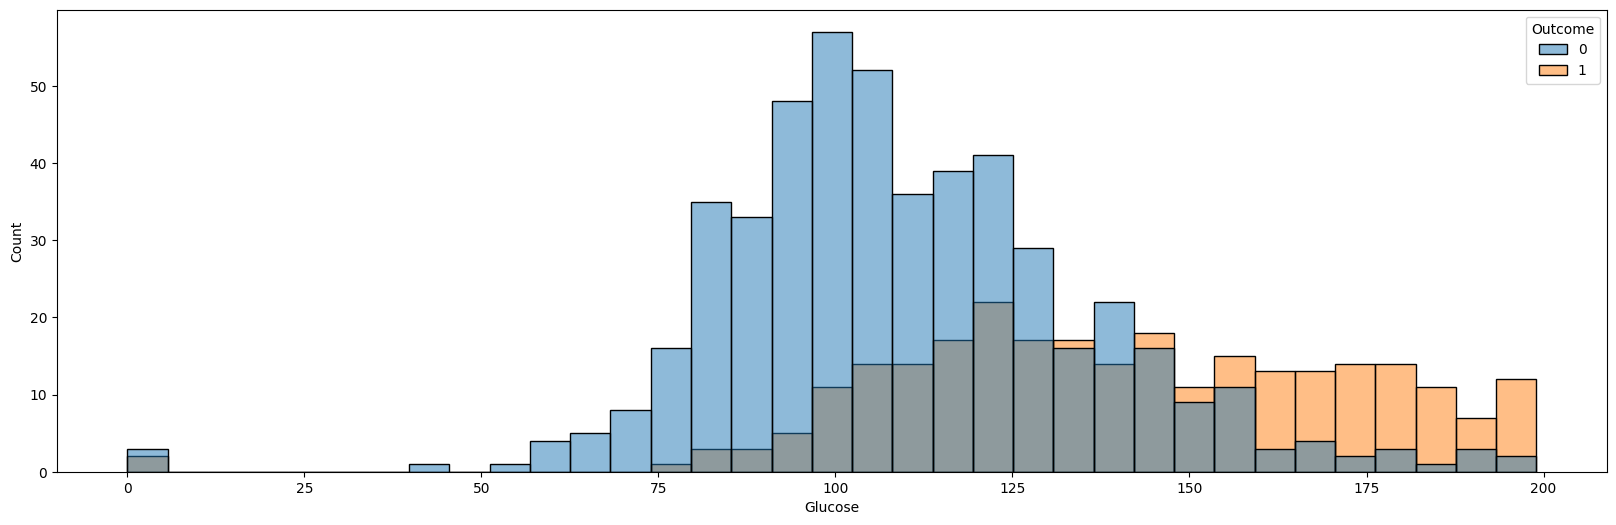

In [23]:
# Glucose 의 수치에 따라 당뇨 확진의 데이터 수를 확인합니다.
plt.figure(figsize=(20, 6))
sns.histplot(x='Glucose', hue='Outcome', data=df_glucose.sort_values('Glucose'), bins=35,)
plt.show()

In [24]:
# 위의 histogram 과 인터넷에서 확인한 당뇨병 확진 포도당 수치를 기준으로 실험한 결과입니다.
# Glucose 를 130 이하, 130 초과일 때 가장 높은 상관관계를 갖습니다.
# 130 이하 -0.42263
# 130 초과 0.42263
df_glucose = df_glucose.apply(
  dataframe_apply_func_axis_1(
    sml_or_eql={'Glucose': 130},
    do_when_true={'Glucose <= 130': 1},
    do_when_false={'Glucose <= 130': 0}
  ),
  axis=1
).apply(
  dataframe_apply_func_axis_1(
    greater_than={'Glucose': 130},
    do_when_true={'130 < Glucose': 1},
    do_when_false={'130 < Glucose': 0}
  ),
  axis=1
)

df_glucose[['Outcome', 'Glucose <= 130', '130 < Glucose']].corr()


NameError: ignored

In [25]:
df_glucose.corr()

,Outcome,Glucose,Insulin,BMI,Age
Outcome,1.000000,0.466581,0.130548,0.292695,0.238356
Glucose,0.466581,1.000000,0.331357,0.221071,0.263514
Insulin,0.130548,0.331357,1.000000,0.197859,-0.042163
BMI,0.292695,0.221071,0.197859,1.000000,0.036242
Age,0.238356,0.263514,-0.042163,0.036242,1.000000


### 포도당 수치를 통해 카테고리화 한다.
#### 카테고리화 할 수치 기준점 실험
- histogram 으로 확인한 포도당 별 당뇨 수와, 인터넷에서 확인한 당뇨병 확진 포도당 수치를 기준으로 실험했다.
- 실험 결과, 130 을 기준으로 130 이하, 130 초과 조건으로 컬럼을 나눴을 때 각 -0.422630, 0.422630 으로 수치가 가장 좋았다.
- Glucose 카테고리화 -> 130을 기준으로 두개의 컬럼으로 나누어 진행함

# 전체 컬럼들의 결측치 확인
- 위의 실험들 중 결측치가 0으로 들어가 있는것을 확인했다.
- 모든 컬럼들에서 켤측치를 미리 확인한다.

In [26]:
col_null_cnt = dict()
for col in df_origin.columns:
    cnt = df_origin.loc[df_origin[col] == 0, [col]].count()
    col_null_cnt[col] = [cnt.values[0]]
pd.DataFrame(col_null_cnt)

,Outcome,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,500,111,5,35,227,374,11,0,0


- Skin Thickness 와 Insulin 의 결측치가 매우 많다.
- 그러나 데이터 양이 매우 적어서 저걸 삭제하면 안될 것 같다.
- 우선 저 데이터들과 Outcome 과의 연관성을 최대한 끌어내보고 대체해보자.

### 인슐린 분석
- 포도당 수치와 상관관계가 높은 인슐린 데이터를 분석하여 포도당 데이터와 결합된 새로운 컬럼을 생성한다.

In [27]:
# 인슐린 결측치 확인 - 768 개의 데이터 중 374 개의 결측치
df_glucose.loc[df_glucose.Insulin == 0].count()

Outcome    374
Glucose    374
Insulin    374
BMI        374
Age        374
dtype: int64

In [28]:
# 인슐린 == 0 인 경우의 데이터 확인
insulin_0 = df_glucose.loc[df_glucose.Insulin == 0]
insulin_0.groupby('Outcome').count()

,Glucose,Insulin,BMI,Age
Outcome,,,,
0,236,236,236,236
1,138,138,138,138


In [29]:
# 결측치를 제거한 dataframe 에서 glucose 와의 상관관계가 0.58 로 높아졌고, 실제 Outcome 과의 상관관계 또한 0.13 에서 0.30 으로 올랐다.
# 결측치를 잘 채워주면 좋은 효과를 얻을 수 있을 것 같다.
df_glucose.loc[df_glucose.Insulin != 0].corr()

,Outcome,Glucose,Insulin,BMI,Age
Outcome,1.000000,0.512201,0.303454,0.271796,0.352982
Glucose,0.512201,1.000000,0.580010,0.208711,0.346041
Insulin,0.303454,0.580010,1.000000,0.228328,0.220261
BMI,0.271796,0.208711,0.228328,1.000000,0.080778
Age,0.352982,0.346041,0.220261,0.080778,1.000000


In [30]:
# 기존 데이터들로 확인 (인슐린과 포도당의 관계성 검증 및 Outcome 과 이어질 수 있는 컬럼 생성)
df_glucose_test = df_glucose.loc[df_glucose.Insulin != 0]
df_glucose_test

,Outcome,Glucose,Insulin,BMI,Age
3,0,89,94,28.1,21
4,1,137,168,43.1,33
6,1,78,88,31.0,26
8,1,197,543,30.5,53
13,1,189,846,30.1,59
...,...,...,...,...,...
753,1,181,510,43.3,26
755,1,128,110,36.5,37
760,0,88,16,28.4,22
763,0,101,180,32.9,63


<Figure size 2000x600 with 0 Axes>

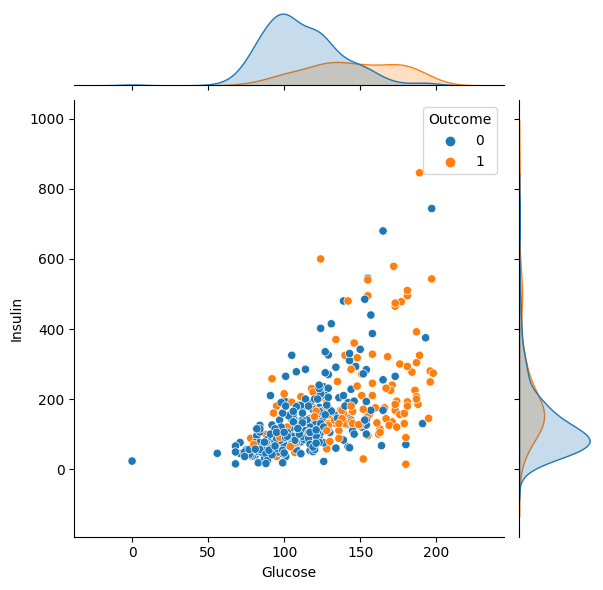

In [31]:
# 인슐린의 수치에 따라 포도당의 수치를 확인합니다.
plt.figure(figsize=(20, 6))
sns.jointplot(x=df_glucose_test['Glucose'], y=df_glucose_test['Insulin'], hue=df_glucose_test['Outcome'], kind = 'scatter')
plt.show()

- 확실히 인슐린의 양이 포도당과 연관되어있나?

In [32]:
# test = df_glucose_test.apply(
#   dataframe_apply_func_axis_1(
#     greater_than={'diff_glc_insln': 80},
#     do_when_true={'diff_glc_insln_huge': 1},
#     do_when_false={'diff_glc_insln_huge': 0},
#   ),
#   axis=1
# )
df_glucose_test['diff_multi'] = (df_glucose_test.Glucose - df_glucose_test.Insulin) * df_glucose_test.Insulin.mean()
df_glucose_test.corr()

<ipython-input-32-1eeff142963f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_glucose_test['diff_multi'] = (df_glucose_test.Glucose - df_glucose_test.Insulin) * df_glucose_test.Insulin.mean()


,Outcome,Glucose,Insulin,BMI,Age,diff_multi
Outcome,1.000000,0.512201,0.303454,0.271796,0.352982,-0.192370
Glucose,0.512201,1.000000,0.580010,0.208711,0.346041,-0.361334
Insulin,0.303454,0.580010,1.000000,0.228328,0.220261,-0.969149
BMI,0.271796,0.208711,0.228328,1.000000,0.080778,-0.198204
Age,0.352982,0.346041,0.220261,0.080778,1.000000,-0.147418
diff_multi,-0.192370,-0.361334,-0.969149,-0.198204,-0.147418,1.000000


# ANN

In [44]:
# df_train에서 "Survived" 컬럼을 제거하여 df_train_x 로 지정.
# df_train에서 "Survived" 를 df_train_y 로 지정하여 output으로 사용.
# dataFrame 형식을 numpy 형식으로 float32변환 후 torch형식으로 변환
df_train_0 = df_train.astype('float32')
df_train_1 = df_train_0.drop("Outcome", axis=1)
df_train_x = df_train_1.to_numpy()

#df_test_0 = df_test.astype('float32')
#df_test_1 = df_test_0.to_numpy()

df_train_y = df_train["Outcome"].to_numpy()

x_train = torch.tensor(df_train_x)
y_train = torch.tensor(df_train_y)

#x_test = torch.tensor(df_test_1)

In [45]:
train_dataset = TensorDataset(x_train, y_train)
#test_dataset = TensorDataset(x_test)

In [46]:
batch_size = 768

# Create data loaders.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [47]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [103]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(), # ReLU로 통과
            #nn.Dropout(0.3),
            nn.Linear(16, 32),
            nn.ReLU(), # ReLU로 통과
            #nn.Dropout(0.3),
            nn.Linear(32, 64),
            nn.ReLU(), # ReLU로 통과
            nn.Dropout(0.3),
            nn.Linear(64, 128),
            nn.ReLU(), # ReLU로 통과
            nn.Dropout(0.3),
            nn.Linear(128, 2),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [104]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 예측 오류 계산
        pred = model(X)
        loss = loss_fn(pred, y)
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            correct /= batch_size
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}] \n Accuracy: {(100*correct):>0.1f}%")

In [105]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():  # gradient 계산을 안한다는 의미
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )

    return test_loss

In [106]:
epochs = 10000
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
print("Done!")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
-------------------------------
loss: 0.381175  [  768/  768] 
 Accuracy: 93.1%
Epoch 8752
-------------------------------
loss: 0.382250  [  768/  768] 
 Accuracy: 93.2%
Epoch 8753
-------------------------------
loss: 0.389691  [  768/  768] 
 Accuracy: 92.2%
Epoch 8754
-------------------------------
loss: 0.381520  [  768/  768] 
 Accuracy: 93.1%
Epoch 8755
-------------------------------
loss: 0.386730  [  768/  768] 
 Accuracy: 92.3%
Epoch 8756
-------------------------------
loss: 0.382999  [  768/  768] 
 Accuracy: 93.0%
Epoch 8757
-------------------------------
loss: 0.385494  [  768/  768] 
 Accuracy: 92.7%
Epoch 8758
-------------------------------
loss: 0.383090  [  768/  768] 
 Accuracy: 93.2%
Epoch 8759
-------------------------------
loss: 0.381201  [  768/  768] 
 Accuracy: 93.2%
Epoch 8760
-------------------------------
loss: 0.382775  [  768/  768] 
 Accuracy: 93.1%
Epoch 8761
-------------------------------
loss: 0.382071  [  768